In [1]:
import pandas as pd
import random
import numpy as np
from ucimlrepo import fetch_ucirepo 

from sklearn.linear_model import LogisticRegression
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from alibi.explainers import ALE, plot_ale
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod

import matplotlib.pyplot as plt

In [83]:
# fetch dataset 
bike_sharing = fetch_ucirepo(id=275) 
  
# data (as pandas dataframes) 
X = bike_sharing.data.features 
y = bike_sharing.data.targets 


In [53]:
X.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'temp_original', 'atemp_original', 'hum_original',
       'windspeed_original'],
      dtype='object')

In [98]:
def get_back_original_data(df):
    """_summary_

    Retransforme les données originales de bike sharing. D'après la documentation 

    Args:
        df (Pandas): Data bike_rental
    """

    temp = df.copy()
    #Température
    temp['temp_original'] = temp['temp'] * (39 - (-8)) + (-8)

    # Température ressentie
    temp['atemp_original'] = temp['atemp'] * (50 - (-16)) + (-16)

    # Humidité
    temp['hum_original'] = temp['hum'] * 100

    # Vitesse du vent
    temp['windspeed_original'] = temp['windspeed'] * 67

    temp = temp.drop(["temp",'atemp','hum','windspeed'],axis=1)

    # Renommer les colonnes pour retirer '_original'
    temp.rename(columns={
        'temp_original': 'temp',
        'atemp_original': 'atemp',
        'hum_original': 'hum',
        'windspeed_original': 'windspeed'
    }, inplace=True)
        
    return(temp)

In [100]:
X_original = get_back_original_data(X)

### Bike sharing demand

Ce jeu de données regroupe la demande journalière de vélo en location.

#### Columns descrbibe 
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter  
    holiday - whether the day is considered a holiday  
    workingday - whether the day is neither a weekend nor holiday  
- weather -
1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  

- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals (Dependent Variable)

## Exploration du dataset  

In [101]:
X_original.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,1,0,1,0,0,6,0,1,3.28,3.0014,81.0,0.0
1,2011-01-01,1,0,1,1,0,6,0,1,2.34,1.9982,80.0,0.0
2,2011-01-01,1,0,1,2,0,6,0,1,2.34,1.9982,80.0,0.0
3,2011-01-01,1,0,1,3,0,6,0,1,3.28,3.0014,75.0,0.0
4,2011-01-01,1,0,1,4,0,6,0,1,3.28,3.0014,75.0,0.0


In [103]:
#One hot encoding des catégories
season_cat = pd.get_dummies(X_original.season, prefix="season")
weathersit_cat = pd.get_dummies(X_original.weathersit, prefix="weathersit")

X_train = pd.concat([X_original, season_cat, weathersit_cat], axis=1)\
            .query("weathersit!=4")\
            .drop(["season","dteday","weathersit"],axis=1)


y_train = y[X_original.weathersit!=4]


In [104]:
# tous les colonnes
features_names = X_train.columns

# Seulement les catégorielels

feature_category = X_train.select_dtypes('uint8').columns

# Les continues

feature_quanti = X_train.select_dtypes(exclude='uint8').columns

### Train model

In [105]:
# Init random forest class
rf = RandomForestRegressor(   n_estimators=250)

In [106]:
rf.fit(X_train, y_train)

c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_estimators=250)

In [107]:
mean_squared_error(rf.predict(X_train), y_train, squared=False)

15.417403718946202

## Partial dependence plot

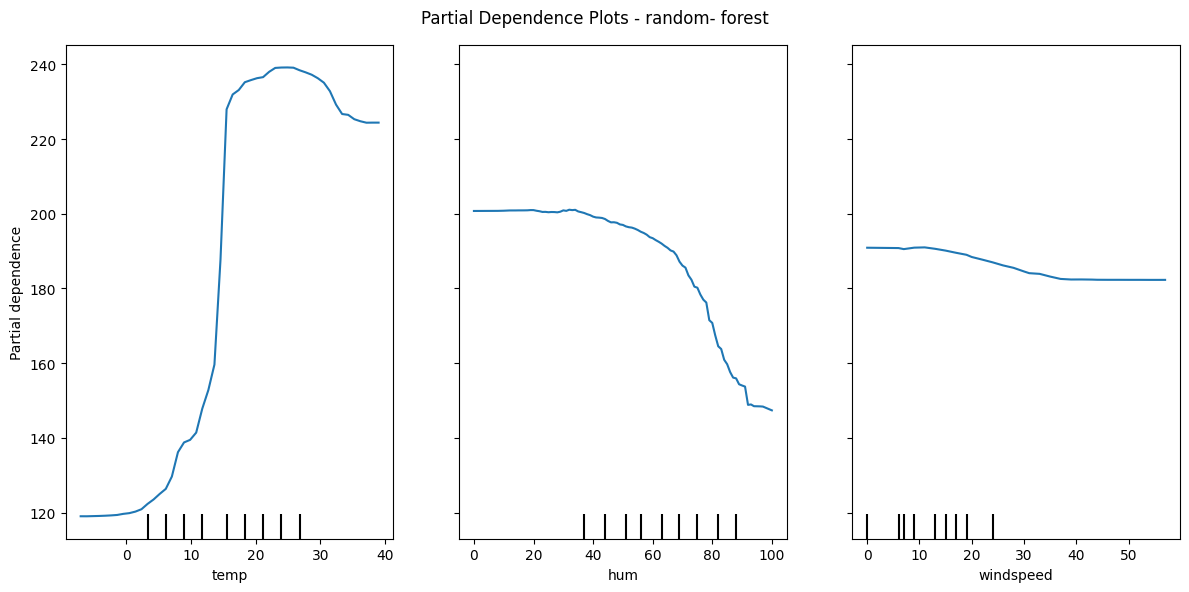

In [108]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["temp","hum","windspeed"]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(rf,  #votre modèle
                                         X_train, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100 # Nombre de points estimés pour le tracer de la courbe
                                         
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

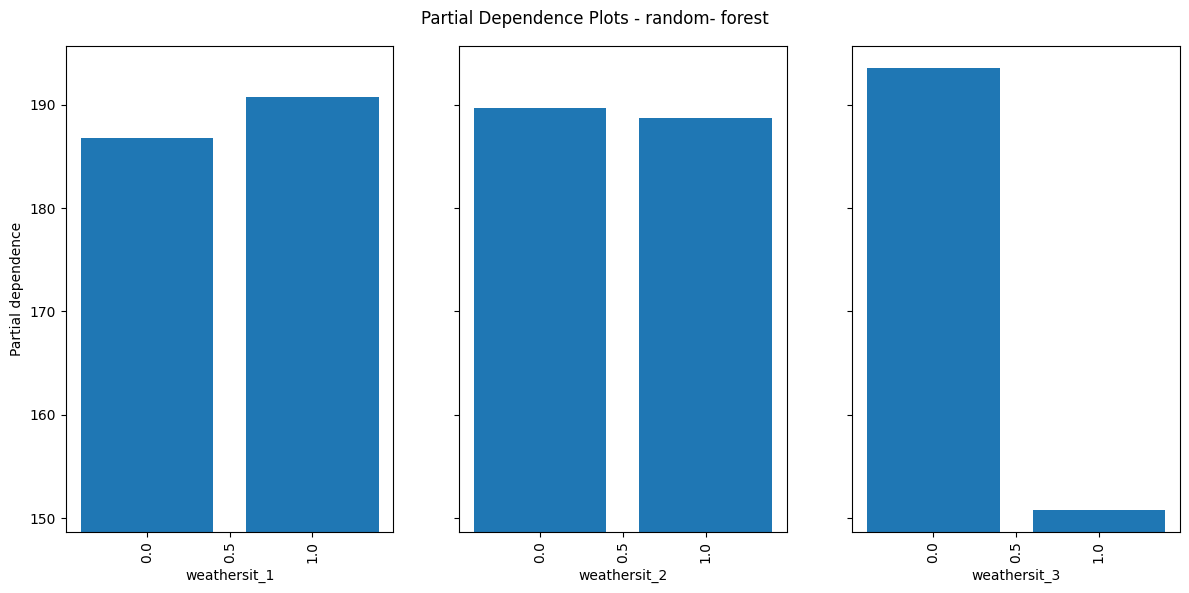

In [109]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["weathersit_1","weathersit_2","weathersit_3"]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(rf, 
                                         X_train, 
                                         features,
                                         categorical_features=["weathersit_1","weathersit_2","weathersit_3"],
                                         kind="average",
                                         grid_resolution=50,
                                         ax = ax1,
                                         n_cols=4
                                         
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()


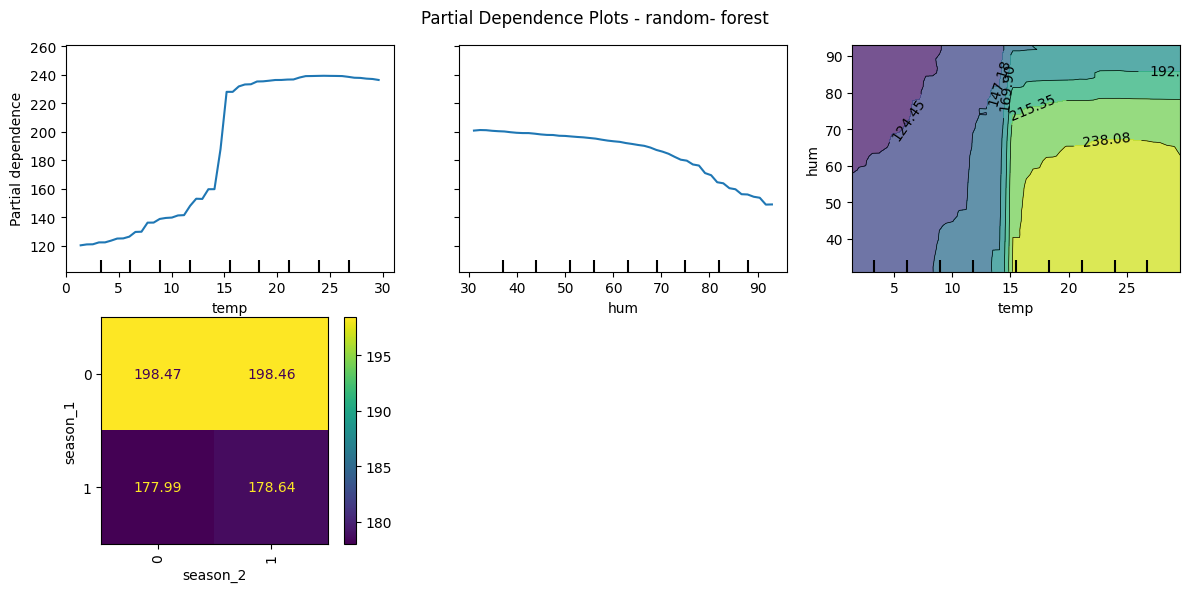

In [110]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["temp","hum",("temp","hum"),("season_1","season_2")]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(rf, 
                                         X_train, 
                                         features,
                                         categorical_features=["season_1","season_2"],
                                         kind="average",
                                         grid_resolution=50,
                                         ax = ax1
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()


### Accumulated local effect

In [111]:
rf_ale = ALE(rf.predict, feature_names=features_names, target_names=["bike sell"])

In [112]:
rf_exp = rf_ale.explain(X_train.to_numpy())

c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fit

array([[<Axes: xlabel='temp', ylabel='ALE'>,
        <Axes: xlabel='hum', ylabel='ALE'>,
        <Axes: xlabel='windspeed', ylabel='ALE'>]], dtype=object)

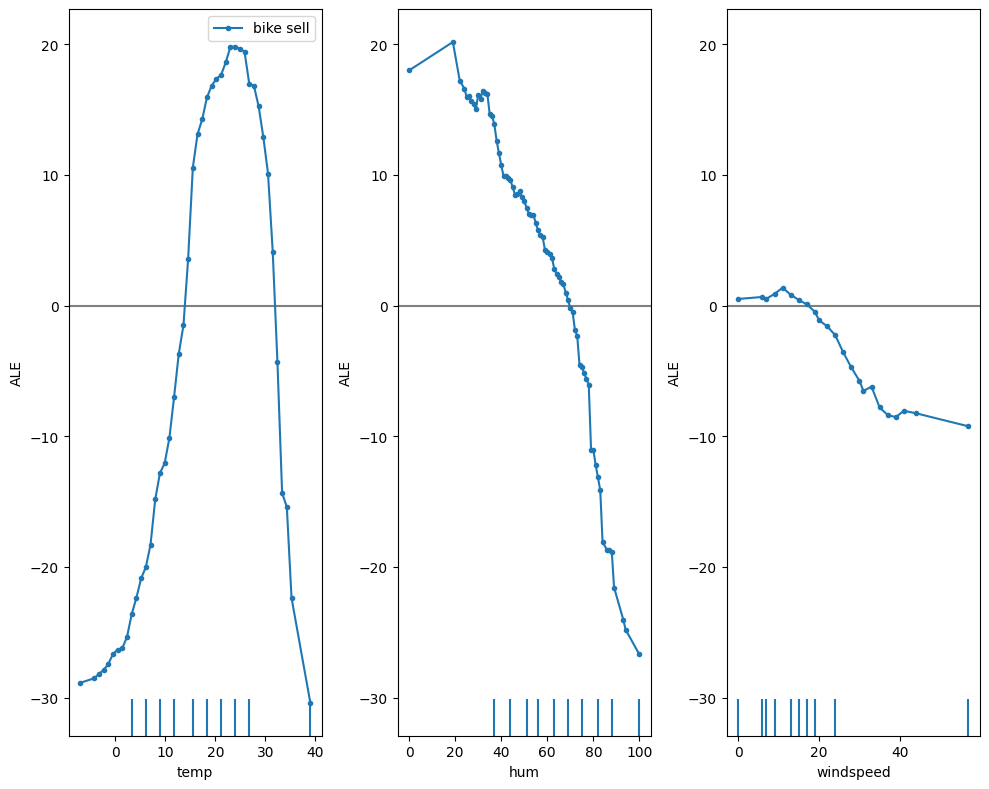

In [113]:
_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(rf_exp, features=["temp","hum","windspeed"], ax= ax1, targets=[0])

### Feature interaction with friedman statistic

In [37]:
random.seed(8)
X_exp = random.choices(X_train.to_numpy(), k=400)
X_exp = pd.DataFrame(X_exp, columns=features_names)

In [38]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(rf, X_exp, batchsize=20)

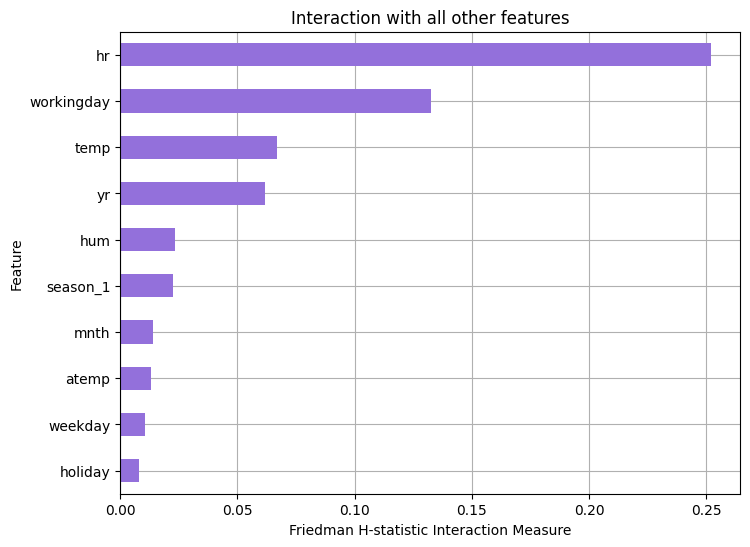

In [41]:
# Interaction One vs All
h_stat.plot(vis_type="bar_chart_ova",top_k=10 )

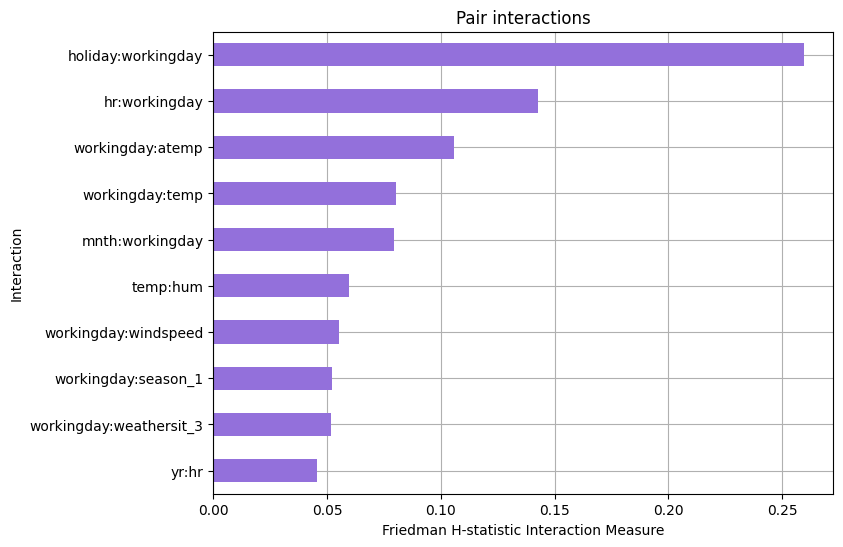

In [ ]:
# Interaction One vs One
h_stat.plot(vis_type="bar_chart",top_k=10 )

Au vu des cette statistique l'interprétation weathersit_2 peut être compliquée car son effet joint avec season_2 explique 55% de sa contribution.
Son interprétation peut donc être fastidieuse


## Feature permutation importance

In [42]:
result = permutation_importance(rf, X_train, y_train,
                           n_repeats=15,
                           random_state=0
                           )


In [43]:
result.importances_mean

array([2.17716334e-01, 3.99349079e-02, 1.39433180e+00, 3.94675661e-03,
       2.69240734e-02, 3.03878582e-01, 1.59839242e-01, 2.87741138e-02,
       6.62171101e-02, 1.07774393e-02, 2.78633734e-02, 8.61220037e-04,
       7.81433458e-04, 1.06768817e-02, 2.43545477e-03, 9.04885990e-04,
       2.34700166e-02, 0.00000000e+00])

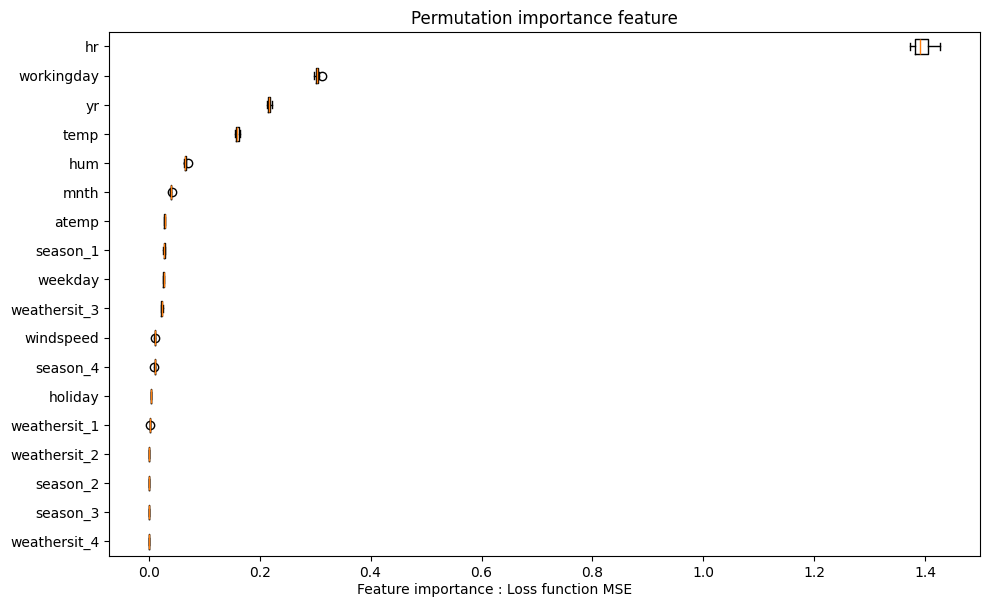

In [44]:
perm_sorted_idx = result.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx]
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function MSE", ha='center')

fig.tight_layout()
plt.show()